# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-random'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    set_seed(seed)
    
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    
    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'fuel': [y_train[i][0] for i in temp],
            'machine': [y_train[i][1] for i in temp],
            'others': [y_train[i][2] for i in temp],
            'part': [y_train[i][3] for i in temp],
            'price': [y_train[i][4] for i in temp],
            'service': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(
            current_train_size, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6285, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5457, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4881, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.475, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4423, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3862, Accuracy: 0.8118, F1 Micro: 0.8935, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3678, Accuracy: 0.8519, F1 Micro: 0.9139, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3303, Accuracy: 0.8616, F1 Micro: 0.9183, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6554, Accuracy: 0.6727, F1 Micro: 0.6727, F1 Macro: 0.4022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5771, Accuracy: 0.6727, F1 Micro: 0.6727, F1 Macro: 0.4022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5227, Accuracy: 0.7212, F1 Micro: 0.7212, F1 Macro: 0.5432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4814, Accuracy: 0.8545, F1 Micro: 0.8545, F1 Macro: 0.8191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4235, Accuracy: 0.8667, F1 Micro: 0.8667, F1 Macro: 0.8403
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2923, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1567, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1427, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5957, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5109, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4791, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4492, Accuracy: 0.8103, F1 Micro: 0.8925, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4093, Accuracy: 0.8251, F1 Micro: 0.9, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3618, Accuracy: 0.8713, F1 Micro: 0.924, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3025, Accuracy: 0.8951, F1 Micro: 0.9366, F1 Macro: 0.9346
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2451, Accuracy: 0.91, F1 Micro: 0.9443, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5976, Accuracy: 0.6826, F1 Micro: 0.6826, F1 Macro: 0.4057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4603, Accuracy: 0.8478, F1 Micro: 0.8478, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3508, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2315, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9229
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9217, F1 Micro: 0.9217, F1 Macro: 0.9132
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.9391, F1 Micro: 0.9391, F1 Macro: 0.9303
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8958
Epoch 10/10, Train Loss: 0.06, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5949, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5103, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4658, Accuracy: 0.8043, F1 Micro: 0.8896, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4102, Accuracy: 0.8259, F1 Micro: 0.9003, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.359, Accuracy: 0.8862, F1 Micro: 0.9312, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3015, Accuracy: 0.907, F1 Micro: 0.9428, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.237, Accuracy: 0.9308, F1 Micro: 0.9572, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1968, Accuracy: 0.9382, F1 Micro: 0.9618, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.589, Accuracy: 0.6763, F1 Micro: 0.6763, F1 Macro: 0.4035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4503, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9345
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9265
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9225
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.0775, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5897, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4862, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4455, Accuracy: 0.8132, F1 Micro: 0.894, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3832, Accuracy: 0.8817, F1 Micro: 0.9297, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3099, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2395, Accuracy: 0.9315, F1 Micro: 0.9574, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1867, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1523, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6266, Accuracy: 0.679, F1 Micro: 0.679, F1 Macro: 0.4387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3701, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2484, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.963, F1 Micro: 0.963, F1 Macro: 0.9589
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9547, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5685, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4697, Accuracy: 0.8036, F1 Micro: 0.8894, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4156, Accuracy: 0.849, F1 Micro: 0.9124, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3295, Accuracy: 0.9122, F1 Micro: 0.9467, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.243, Accuracy: 0.942, F1 Micro: 0.9641, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1996, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1448, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1199, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5922, Accuracy: 0.7009, F1 Micro: 0.7009, F1 Macro: 0.5413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.434, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.235, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9487, F1 Micro: 0.9487, F1 Macro: 0.943
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9353
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1042, Accuracy: 0.953, F1 Micro: 0.953, F1 Macro: 0.9488
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9487, F1 Micro: 0.9487, F1 Macro: 0.9437
Epoch 10/10, Train Loss: 0.0839, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5608, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4801, Accuracy: 0.8088, F1 Micro: 0.8918, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4015, Accuracy: 0.8795, F1 Micro: 0.9279, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3137, Accuracy: 0.9353, F1 Micro: 0.9601, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2313, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1782, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.135, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1098, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5595, Accuracy: 0.8175, F1 Micro: 0.8175, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1443, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9076
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9168
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9187
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9168
Epoch 8/10, Train Loss: 0.1266, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9252
Epoch 10/10, Train Loss: 0.0656, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5552, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4789, Accuracy: 0.8095, F1 Micro: 0.8922, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3919, Accuracy: 0.8847, F1 Micro: 0.93, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3084, Accuracy: 0.9323, F1 Micro: 0.9579, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2261, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1827, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1125, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0915, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5625, Accuracy: 0.7262, F1 Micro: 0.7262, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2901, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9009
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9425
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9425
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5441, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4606, Accuracy: 0.8356, F1 Micro: 0.9054, F1 Macro: 0.9049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3628, Accuracy: 0.9256, F1 Micro: 0.9546, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2591, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9682
Epoch 5/10, Train Loss: 0.1984, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1475, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8576
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2831, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.8794, F1 Micro: 0.8794, F1 Macro: 0.8709
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9231
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9222
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9301
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9343

Sentiment analysis accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4569, Accuracy: 0.8177, F1 Micro: 0.8963, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3714, Accuracy: 0.9286, F1 Micro: 0.9562, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2707, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1958, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9621, F1 Micro: 0.9762, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5387, Accuracy: 0.8496, F1 Micro: 0.8496, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9328
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9458
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9414
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.9548
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9316
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9316

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5476, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4589, Accuracy: 0.8274, F1 Micro: 0.9014, F1 Macro: 0.9002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3441, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2402, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9664
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.965, F1 Micro: 0.9781, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5211, Accuracy: 0.7912, F1 Micro: 0.7912, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9259
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9367
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9301
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.947
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0743, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5344, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4686, Accuracy: 0.8371, F1 Micro: 0.9063, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3397, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2309, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.53, Accuracy: 0.8508, F1 Micro: 0.8508, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2809, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9271
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.917
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9228
Epoch 6/10, Train Loss: 0.1614, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9323
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9132
Epoch 9/10, Train Loss: 0.0992, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9284
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9175

Sentiment analysis accuracy: 0.9395, F1 Micro: 0.9395

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4501, Accuracy: 0.8504, F1 Micro: 0.9131, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3336, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2202, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5319, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2219, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9249
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9173
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9114
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9098
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8946
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9128
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9169

Sentiment analysis accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9249
              precision    recall  f1-sc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5359, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.8795, F1 Micro: 0.9279, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3104, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2121, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving mo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5004, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.8719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9299
Epoch 3/10, Train Loss: 0.1531, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9138
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9321
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9175
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0768, Accuracy: 0.9407, F1 Micro: 0.9407, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4425, Accuracy: 0.8765, F1 Micro: 0.9269, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3115, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5321, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9027
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9173
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5363, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.442, Accuracy: 0.8832, F1 Micro: 0.9302, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3058, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2116, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9776
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5148, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9375
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9307
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9332
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9259
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9375
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9427
Epoch 10/10, Train Loss: 0.0761, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9259

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4213, Accuracy: 0.9211, F1 Micro: 0.9519, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2854, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4872, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9297
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9333
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9202
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0566, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5305, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4111, Accuracy: 0.9137, F1 Micro: 0.9479, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2826, Accuracy: 0.9382, F1 Micro: 0.9614, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2872, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9279
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5417, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4275, Accuracy: 0.9055, F1 Micro: 0.943, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2696, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1939, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.481, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9442
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9398
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.42, Accuracy: 0.9189, F1 Micro: 0.9507, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.273, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9813
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4764, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.915
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9113
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.9256, F1 Micro: 0.9546, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2643, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4998, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9427
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9063
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9144
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9185
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9181
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9297

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.8095, F1 Micro: 0.8921, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4033, Accuracy: 0.9144, F1 Micro: 0.9472, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2582, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.98
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4737, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9533
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9214
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5287, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3915, Accuracy: 0.9301, F1 Micro: 0.9568, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2487, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 10/10, Train Loss: 0.0467, Accuracy: 0.9673, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2016, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Epoch 4/10, Train Loss: 0.1046, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9271
Epoch 6/10, Train Loss: 0.0647, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9255
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9392
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5277, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3887, Accuracy: 0.9308, F1 Micro: 0.9577, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9722
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4854, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1323, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9079
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9481
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9258, F1 Micro: 0.9258, F1 

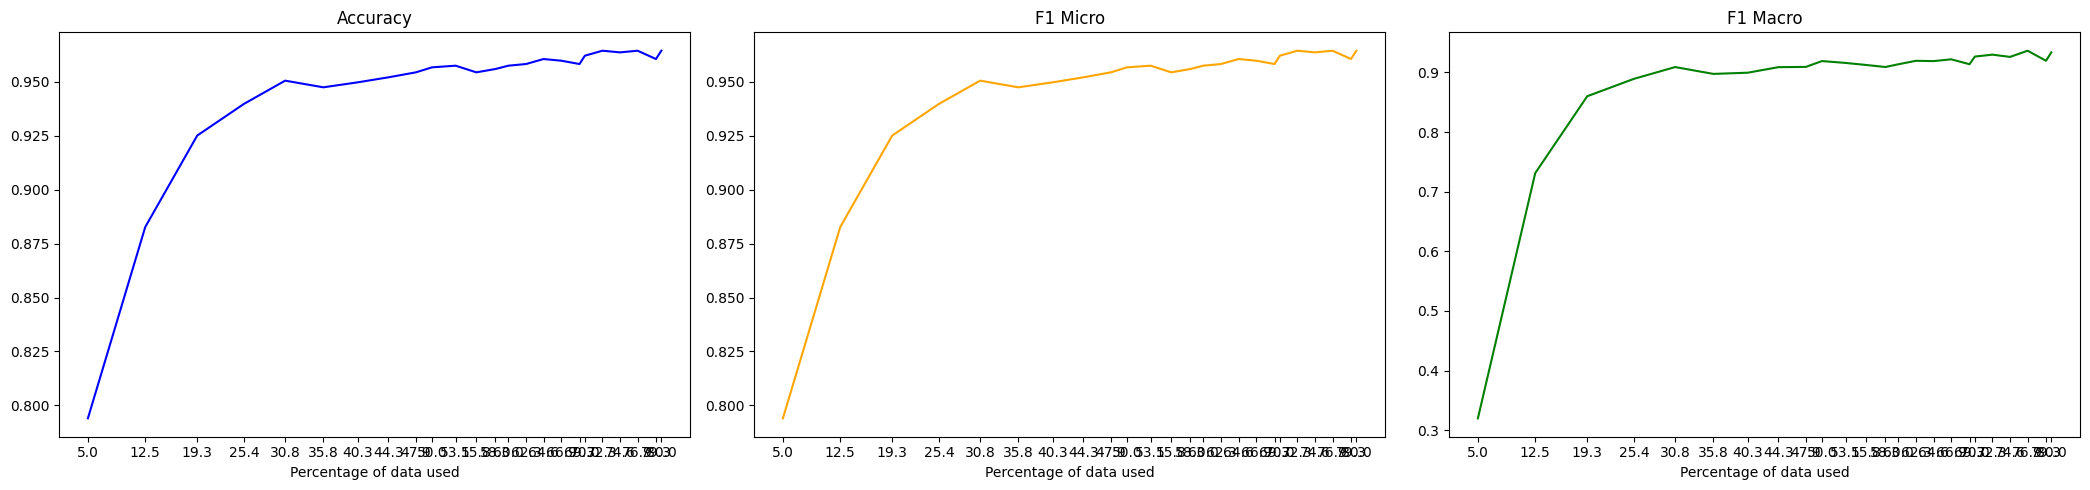

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.61, Accuracy: 0.7946, F1 Micro: 0.8842, F1 Macro: 0.8824
Epoch 2/10, Train Loss: 0.5099, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4873, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4276, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4015, Accuracy: 0.8155, F1 Micro: 0.8948, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3452, Accuracy: 0.8482, F1 Micro: 0.9106, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3183, Accuracy: 0.872, F1 Micro: 0.9225, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2898, Accuracy: 0.8802, F1 Micro: 0.9261, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2431, Accuracy: 0.8906, F1 Micro: 0.9326, F1 Macro: 0.9292
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6331, Accuracy: 0.7137, F1 Micro: 0.7137, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.527, Accuracy: 0.7137, F1 Micro: 0.7137, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5339, Accuracy: 0.7137, F1 Micro: 0.7137, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.432, Accuracy: 0.7552, F1 Micro: 0.7552, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3908, Accuracy: 0.8423, F1 Micro: 0.8423, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2221, Accuracy: 0.8589, F1 Micro: 0.8589, F1 Macro: 0.8274
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2522, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2318, Accuracy: 0.8838, F1 Micro: 0.8838, F1 Macro: 0.8566
Epoch 9/10, Train Loss: 0.1582, Accuracy: 0.8714, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5971, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5018, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4857, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4384, Accuracy: 0.7999, F1 Micro: 0.8873, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.398, Accuracy: 0.8564, F1 Micro: 0.9153, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3295, Accuracy: 0.8996, F1 Micro: 0.9388, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2754, Accuracy: 0.9174, F1 Micro: 0.9488, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2183, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5951, Accuracy: 0.6923, F1 Micro: 0.6923, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5336, Accuracy: 0.6964, F1 Micro: 0.6964, F1 Macro: 0.4231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4192, Accuracy: 0.8259, F1 Micro: 0.8259, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2762, Accuracy: 0.8583, F1 Micro: 0.8583, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1819, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.148, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9125
Epoch 8/10, Train Loss: 0.1187, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1465, Accuracy: 0.9271, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.57, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4931, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4678, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4058, Accuracy: 0.8832, F1 Micro: 0.9291, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3283, Accuracy: 0.9182, F1 Micro: 0.9498, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2606, Accuracy: 0.9278, F1 Micro: 0.9551, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2092, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9627
Epoch 8/10, Train Loss: 0.1645, Accuracy: 0.942, F1 Micro: 0.9638, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.126, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.582, Accuracy: 0.6708, F1 Micro: 0.6708, F1 Macro: 0.4015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4749, Accuracy: 0.8354, F1 Micro: 0.8354, F1 Macro: 0.8042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3063, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2106, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9167
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8978
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.908
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1332, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9172
Epoch 10/10, Train Loss: 0.0678, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.566, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4818, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4422, Accuracy: 0.8348, F1 Micro: 0.9051, F1 Macro: 0.904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3439, Accuracy: 0.9241, F1 Micro: 0.9532, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2819, Accuracy: 0.9308, F1 Micro: 0.9574, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2104, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1581, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Epoch 8/10, Train Loss: 0.1323, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1007, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.633, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4632, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9367, F1 Micro: 0.9367, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1341, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9367, F1 Micro: 0.9367, F1 Macro: 0.9307
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9578, F1 Micro: 0.9578, F1 Macro: 0.9534
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5503, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4821, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3986, Accuracy: 0.8981, F1 Micro: 0.9383, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2959, Accuracy: 0.9286, F1 Micro: 0.9559, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9692
Epoch 6/10, Train Loss: 0.1771, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1404, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9694
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9687
Epoch 9/10, Train Loss: 0.0889, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9687
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.595, Accuracy: 0.684, F1 Micro: 0.684, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4035, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9333
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9199
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9202
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9211
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9326
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9077
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9207

Sentiment analysis accuracy: 0.94, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5466, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.465, Accuracy: 0.8088, F1 Micro: 0.892, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3827, Accuracy: 0.9159, F1 Micro: 0.9486, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2858, Accuracy: 0.9301, F1 Micro: 0.957, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2156, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1715, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9713
Epoch 9/10, Train Loss: 0.0819, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.6772, F1 Micro: 0.6772, F1 Macro: 0.4038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4389, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9176
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9094
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9255
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9209
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9054
Epoch 10/10, Train Loss: 0.0568, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9218

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.546, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4598, Accuracy: 0.8058, F1 Micro: 0.8905, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3645, Accuracy: 0.9159, F1 Micro: 0.9479, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2689, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9684
Epoch 5/10, Train Loss: 0.1942, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9667
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.12, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9691
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6248, Accuracy: 0.6926, F1 Micro: 0.6926, F1 Macro: 0.4211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3928, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9152
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9172
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.905
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9063
Epoch 8/10, Train Loss: 0.1197, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8988
Epoch 9/10, Train Loss: 0.0922, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0742, Accuracy: 0.9261, F1 Micro: 0.9261, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5417, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4591, Accuracy: 0.8497, F1 Micro: 0.913, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3426, Accuracy: 0.9301, F1 Micro: 0.9568, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2486, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.971
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5725, Accuracy: 0.7093, F1 Micro: 0.7093, F1 Macro: 0.4997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9215
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Epoch 4/10, Train Loss: 0.122, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8912
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9057
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9102
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.907
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9252
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9169

Sentiment analysis accuracy: 0.9341, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5342, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4629, Accuracy: 0.8586, F1 Micro: 0.9174, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3309, Accuracy: 0.9293, F1 Micro: 0.9563, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2329, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1451, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9692
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5822, Accuracy: 0.7318, F1 Micro: 0.7318, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3454, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9252
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9192
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9112
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.921
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9188
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9032
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.922
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9148

Sentiment analysis accuracy: 0.9349, F1 Micro: 0.9349, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4459, Accuracy: 0.8482, F1 Micro: 0.9121, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3352, Accuracy: 0.9278, F1 Micro: 0.9553, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2375, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1836, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0688, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5695, Accuracy: 0.7615, F1 Micro: 0.7615, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3162, Accuracy: 0.8769, F1 Micro: 0.8769, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9338
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9115
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.925
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9269, F1 Micro: 0.9269, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4472, Accuracy: 0.8862, F1 Micro: 0.9317, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3061, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2259, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0635, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5476, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.8805, F1 Micro: 0.8805, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.925
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.9011
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9167
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.925
Epoch 10/10, Train Loss: 0.0535, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4257, Accuracy: 0.8802, F1 Micro: 0.929, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2973, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2221, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5621, Accuracy: 0.711, F1 Micro: 0.711, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3345, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9488
Epoch 9/10, Train Loss: 0.1098, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9313
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324

Sentiment analysis accuracy: 0.9544, F1 Micro: 0.9544,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5265, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4142, Accuracy: 0.9085, F1 Micro: 0.9438, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9709
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5504, Accuracy: 0.8774, F1 Micro: 0.8774, F1 Macro: 0.8558
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9348
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9129
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9075
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9174
Epoch 9/10, Train Loss: 0.1133, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0643, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397

Sentiment analysis accuracy: 0.9464, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3964, Accuracy: 0.9115, F1 Micro: 0.9455, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2639, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0559, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5289, Accuracy: 0.8716, F1 Micro: 0.8716, F1 Macro: 0.8508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9222
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9044
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9343
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9301
Epoch 10/10, Train Loss: 0.0633, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9293

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5353, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4139, Accuracy: 0.9174, F1 Micro: 0.9492, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2864, Accuracy: 0.9457, F1 Micro: 0.9665, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5377, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1414, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.1034, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9256
Epoch 5/10, Train Loss: 0.0796, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9217
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9491
Epoch 10/10, Train Loss: 0.0841, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5351, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4181, Accuracy: 0.9115, F1 Micro: 0.9461, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2901, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2227, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.908
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.904
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9119
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3856, Accuracy: 0.9174, F1 Micro: 0.9488, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5433, Accuracy: 0.8696, F1 Micro: 0.8696, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1492, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9474
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9341
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9419
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9517
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9472
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9526, F1 Micro: 0.9526, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.528, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3928, Accuracy: 0.9182, F1 Micro: 0.9491, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2572, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9719
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.8647, F1 Micro: 0.8647, F1 Macro: 0.8574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1083, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0866, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9456
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9453
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9375
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9415
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9217
Epoch 10/10, Train Loss: 0.054, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5225, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3824, Accuracy: 0.9271, F1 Micro: 0.9548, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2582, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5918, Accuracy: 0.6866, F1 Micro: 0.6866, F1 Macro: 0.4071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2321, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9323
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9056
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9203
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9397
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9179
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9247
Epoch 10/10, Train Loss: 0.0573, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9129

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5237, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3722, Accuracy: 0.9234, F1 Micro: 0.9526, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2386, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9735
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9799
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9635, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4936, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9215
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5197, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3777, Accuracy: 0.9144, F1 Micro: 0.9463, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9717, F1 Micro: 0.9823, F1 Macro: 0.9814
Epoch 9/10, Train Loss: 0.0532, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4925, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9426
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9265
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9183
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9261
Epoch 10/10, Train Loss: 0.0573, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9299

Sentiment analysis accuracy: 0.9486, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3674, Accuracy: 0.9308, F1 Micro: 0.9569, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9725, F1 Micro: 0.9826, F1 Macro: 0.9815
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5305, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1374, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9284
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9022
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5153, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3644, Accuracy: 0.9375, F1 Micro: 0.961, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2347, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9717, F1 Micro: 0.9823, F1 Macro: 0.9815
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.98
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9788
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.8376
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9235
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9438
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9348
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9216
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro

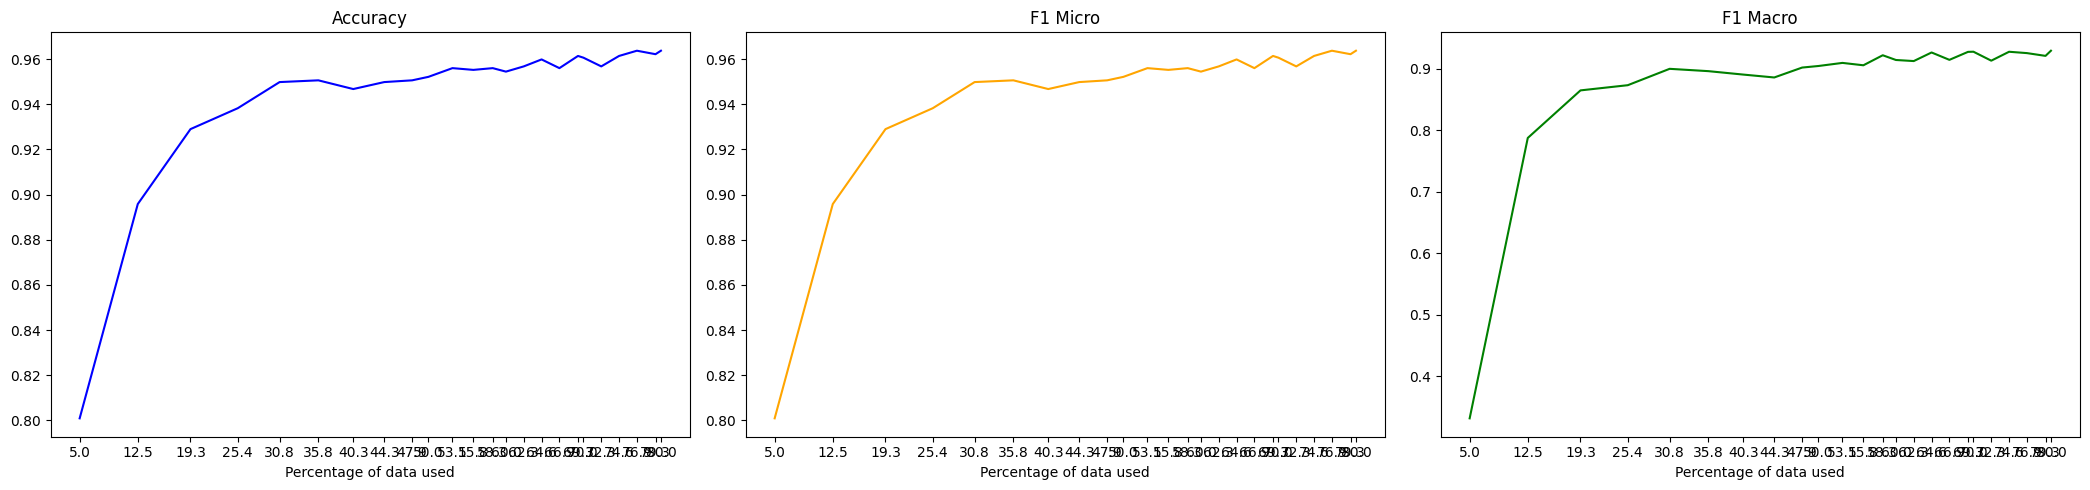

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6263, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5048, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4788, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4555, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4282, Accuracy: 0.7946, F1 Micro: 0.8847, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3763, Accuracy: 0.8155, F1 Micro: 0.8944, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3213, Accuracy: 0.8341, F1 Micro: 0.9032, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2999, Accuracy: 0.8571, F1 Micro: 0.9145, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5951, Accuracy: 0.702, F1 Micro: 0.702, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4643, Accuracy: 0.702, F1 Micro: 0.702, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3406, Accuracy: 0.702, F1 Micro: 0.702, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.798, F1 Micro: 0.798, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.243, Accuracy: 0.8485, F1 Micro: 0.8485, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.8485, F1 Micro: 0.8485, F1 Macro: 0.7966
Epoch 7/10, Train Loss: 0.1599, Accuracy: 0.8384, F1 Micro: 0.8384, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.8362
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.8196
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5882, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4947, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.467, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4319, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3916, Accuracy: 0.8363, F1 Micro: 0.9052, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3338, Accuracy: 0.8616, F1 Micro: 0.9166, F1 Macro: 0.9134
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2791, Accuracy: 0.8906, F1 Micro: 0.9333, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.222, Accuracy: 0.9048, F1 Micro: 0.9414, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6385, Accuracy: 0.6635, F1 Micro: 0.6635, F1 Macro: 0.3989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5007, Accuracy: 0.6635, F1 Micro: 0.6635, F1 Macro: 0.3989
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3518, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2691, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9479, F1 Micro: 0.9479, F1 Macro: 0.9401
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9222
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9051
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9272
Epoch 10/10, Train Loss: 0.0498, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5708, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4396, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3944, Accuracy: 0.8445, F1 Micro: 0.9095, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3369, Accuracy: 0.8966, F1 Micro: 0.9374, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2626, Accuracy: 0.9159, F1 Micro: 0.9481, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2248, Accuracy: 0.9278, F1 Micro: 0.9554, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1718, Accuracy: 0.9315, F1 Micro: 0.9578, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.148, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6127, Accuracy: 0.6562, F1 Micro: 0.6562, F1 Macro: 0.3962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5049, Accuracy: 0.7723, F1 Micro: 0.7723, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3391, Accuracy: 0.9196, F1 Micro: 0.9196, F1 Macro: 0.9134
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9184
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9454
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9189
Epoch 10/10, Train Loss: 0.059, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4855, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4358, Accuracy: 0.811, F1 Micro: 0.893, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3785, Accuracy: 0.8884, F1 Micro: 0.9326, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2855, Accuracy: 0.9219, F1 Micro: 0.9517, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2277, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1913, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1411, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9692
Epoch 9/10, Train Loss: 0.1114, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6029, Accuracy: 0.6608, F1 Micro: 0.6608, F1 Macro: 0.3979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4718, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2891, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0954, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9359
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9223
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9295, F1 Micro: 0.9295, F1 Macro: 0.9214
Epoch 8/10, Train Loss: 0.1075, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9332
Epoch 9/10, Train Loss: 0.0984, Accuracy: 0.9207, F1 Micro: 0.9207, F1 Macro: 0.9078
Epoch 10/10, Train Loss: 0.0904, Accuracy: 0.9207, F1 Micro: 0.9207, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5497, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4902, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4094, Accuracy: 0.8571, F1 Micro: 0.9167, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3163, Accuracy: 0.9226, F1 Micro: 0.9524, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2395, Accuracy: 0.9323, F1 Micro: 0.9578, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.203, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1519, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9681
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1054, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5929, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3467, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9437, F1 Micro: 0.9437, F1 Macro: 0.9384
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9437, F1 Micro: 0.9437, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9437, F1 Micro: 0.9437, F1 Macro: 0.9369
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9335
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9285
Epoch 9/10, Train Loss: 0.1058, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9327
Epoch 10/10, Train Loss: 0.0724, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4672, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4129, Accuracy: 0.8847, F1 Micro: 0.9313, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3145, Accuracy: 0.9278, F1 Micro: 0.9556, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.232, Accuracy: 0.9405, F1 Micro: 0.9631, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1839, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1461, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.969
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6254, Accuracy: 0.7961, F1 Micro: 0.7961, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3791, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9243
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.921
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.929
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9243
Epoch 8/10, Train Loss: 0.1165, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0965, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0901, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5478, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4679, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3877, Accuracy: 0.8765, F1 Micro: 0.9252, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2971, Accuracy: 0.9271, F1 Micro: 0.955, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2142, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9644
Epoch 6/10, Train Loss: 0.1672, Accuracy: 0.9427, F1 Micro: 0.9641, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1358, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9706
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5462, Accuracy: 0.6965, F1 Micro: 0.6965, F1 Macro: 0.445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9199
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9044
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9116
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9288
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1135, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.949

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4545, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3691, Accuracy: 0.91, F1 Micro: 0.9449, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2536, Accuracy: 0.9382, F1 Micro: 0.9617, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1865, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5709, Accuracy: 0.682, F1 Micro: 0.682, F1 Macro: 0.4512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9354
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9372, F1 Micro: 0.9372, F1 Macro: 0.9313
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.9372, F1 Micro: 0.9372, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9456, F1 Micro: 0.9456, F1 Macro: 0.9402
Epoch 7/10, Train Loss: 0.1436, Accuracy: 0.9372, F1 Micro: 0.9372, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9456, F1 Micro: 0.9456, F1 Macro: 0.9395
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.927
Epoch 10/10, Train Loss: 0.0584, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4725, Accuracy: 0.8088, F1 Micro: 0.8914, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3731, Accuracy: 0.9025, F1 Micro: 0.9416, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2728, Accuracy: 0.9494, F1 Micro: 0.9688, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1983, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1516, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0766, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5695, Accuracy: 0.7757, F1 Micro: 0.7757, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.92
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9141
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9172
Epoch 10/10, Train Loss: 0.1072, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9167

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5443, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4689, Accuracy: 0.8207, F1 Micro: 0.8979, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3507, Accuracy: 0.9226, F1 Micro: 0.9525, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2545, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.195, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5861, Accuracy: 0.7846, F1 Micro: 0.7846, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9395
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 5/10, Train Loss: 0.1592, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9199
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9476
Epoch 10/10, Train Loss: 0.0658, Accuracy: 0.9462, F1 Micro: 0.9462, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5319, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4658, Accuracy: 0.846, F1 Micro: 0.9097, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3489, Accuracy: 0.9278, F1 Micro: 0.9554, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2292, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9709
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4986, Accuracy: 0.8769, F1 Micro: 0.8769, F1 Macro: 0.8608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1492, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9364
Epoch 8/10, Train Loss: 0.1198, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9051
Epoch 9/10, Train Loss: 0.1024, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9046
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5438, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.448, Accuracy: 0.8557, F1 Micro: 0.9157, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3198, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2145, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.552, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2986, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9463, F1 Micro: 0.9463, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9491
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9628, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4483, Accuracy: 0.8772, F1 Micro: 0.9269, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3118, Accuracy: 0.9301, F1 Micro: 0.9563, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5393, Accuracy: 0.8696, F1 Micro: 0.8696, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9605, F1 Micro: 0.9605, F1 Macro: 0.956
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9183
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9348
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9345
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9472
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4396, Accuracy: 0.8571, F1 Micro: 0.9152, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.9382, F1 Micro: 0.9616, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9613, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5057, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9553
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9219
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9298
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9219
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.929
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379
Epoch 10/10, Train Loss: 0.059, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.934

Sentiment analysis accuracy: 0.9608, F1 Micro: 0.9608,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5401, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4384, Accuracy: 0.8631, F1 Micro: 0.9197, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3134, Accuracy: 0.9427, F1 Micro: 0.9646, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9751
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5162, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9461
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9418
Epoch 5/10, Train Loss: 0.0969, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9552, F1 Micro: 0.9552, F1 Macro: 0.9498
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9414
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9334
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9291
Epoch 10/10, Train Loss: 0.0687, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9224

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4189, Accuracy: 0.8847, F1 Micro: 0.9313, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2899, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9746
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4981, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9483
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9693, F1 Micro: 0.9693, F1 Macro: 0.9653
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9486
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4152, Accuracy: 0.8966, F1 Micro: 0.9366, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2789, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1876, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.508, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2222, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9382
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1228, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9382
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9345, F1 Micro: 0.9345, F1 Macro: 0.9265
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9345, F1 Micro: 0.9345, F1 Macro: 0.9265
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9273, F1 Micro: 0.9273, F1 Macro: 0.9188
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9273, F1 Micro: 0.9273, F1 Macro: 0.9188
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.9418, F1 Micro: 0.9418, F1 Macro: 0.9343

Sentiment analysis accuracy: 0.9455, F1 Micro: 0.9455

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.522, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.415, Accuracy: 0.9048, F1 Micro: 0.9424, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2692, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5175, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9493
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9256
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 10/10, Train Loss: 0.0621, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5189, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.8981, F1 Micro: 0.9388, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9787
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.9528
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9429
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.9523
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9614, F1 Micro: 0.9614, F1 Macro: 0.9565
Epoch 10/10, Train Loss: 0.0741, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5177, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3817, Accuracy: 0.9249, F1 Micro: 0.9542, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2533, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2302, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9266
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1195, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.956
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.952
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9314
Epoch 9/10, Train Loss: 0.1009, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9466
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5333, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4106, Accuracy: 0.9226, F1 Micro: 0.9525, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.254, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4913, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9198
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9402
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9238
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9121
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9479
Epoch 10/10, Train Loss: 0.073, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5147, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3913, Accuracy: 0.9234, F1 Micro: 0.9527, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2423, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9762
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9332
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1253, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9456
Epoch 5/10, Train Loss: 0.0979, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9325
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9699, F1 Micro: 0.9699, F1 Macro: 0.966
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9296
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9624, F1 Micro: 0.9624, F1 Macro: 0.9578
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9493

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5227, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4039, Accuracy: 0.9256, F1 Micro: 0.954, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4835, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2092, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9366
Epoch 3/10, Train Loss: 0.1544, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9214
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9269
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9583, F1 Micro: 0.9583, F1 Macro: 0.953
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9451
Epoch 10/10, Train Loss: 0.0631, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro

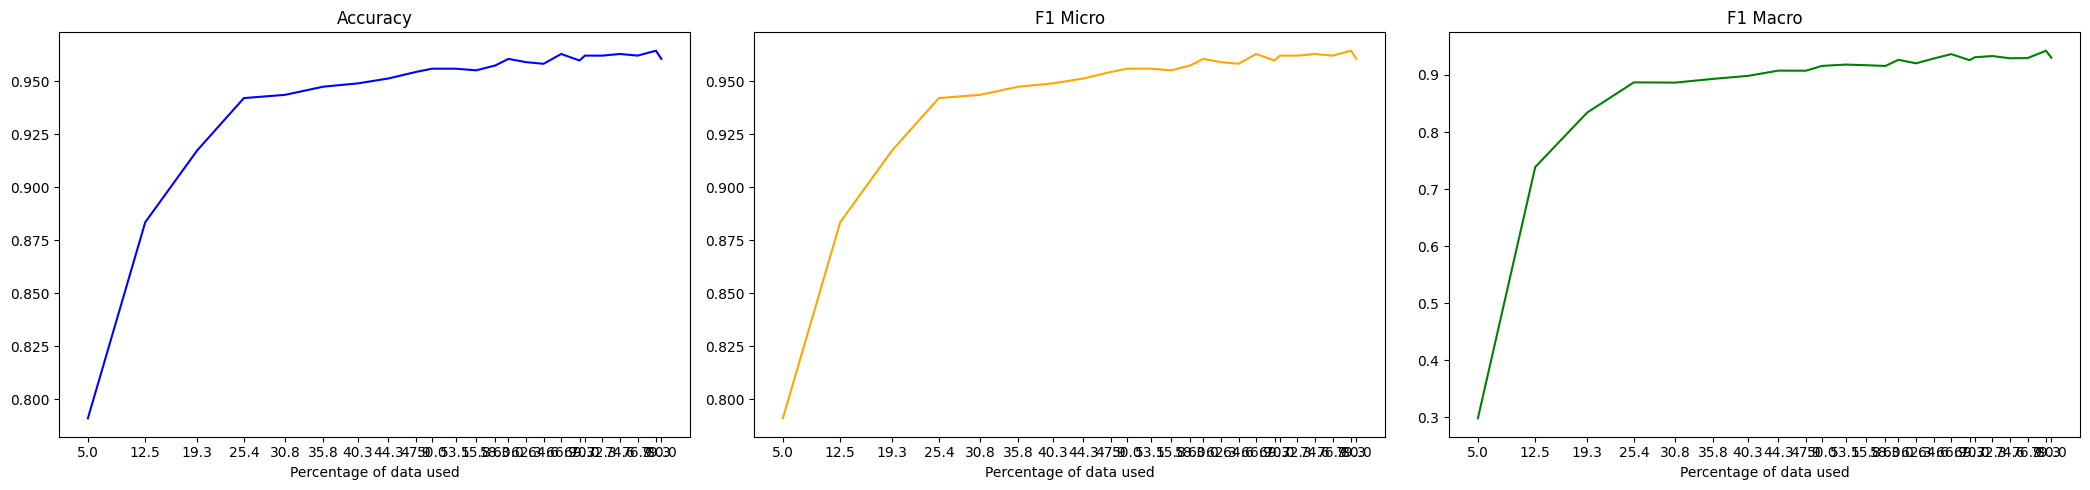

In [24]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.608, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5221, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 3/10, Train Loss: 0.5085, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5013, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4677, Accuracy: 0.7961, F1 Micro: 0.8852, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4161, Accuracy: 0.8051, F1 Micro: 0.889, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3802, Accuracy: 0.8289, F1 Micro: 0.8999, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3468, Accuracy: 0.8586, F1 Micro: 0.9164, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.299, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6402, Accuracy: 0.7253, F1 Micro: 0.7253, F1 Macro: 0.4204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5392, Accuracy: 0.7253, F1 Micro: 0.7253, F1 Macro: 0.4204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4896, Accuracy: 0.7418, F1 Micro: 0.7418, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3574, Accuracy: 0.8407, F1 Micro: 0.8407, F1 Macro: 0.7935
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2337, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1239, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8836
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9011, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5925, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5244, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.5024, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4704, Accuracy: 0.7976, F1 Micro: 0.8857, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4177, Accuracy: 0.8177, F1 Micro: 0.8953, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3871, Accuracy: 0.8467, F1 Micro: 0.9101, F1 Macro: 0.9083
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3321, Accuracy: 0.8981, F1 Micro: 0.9386, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2845, Accuracy: 0.9174, F1 Micro: 0.9493, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2278, Accuracy: 0.9256, F1 Micro: 0.9543, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5894, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5361, Accuracy: 0.7042, F1 Micro: 0.7042, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.353, Accuracy: 0.831, F1 Micro: 0.831, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2198, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0524, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9296, F1 Micro: 0.9296, F1 Macro: 0.9199
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9085
Epoch 9/10, Train Loss: 0.0163, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8902
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5144, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4747, Accuracy: 0.7946, F1 Micro: 0.8841, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4323, Accuracy: 0.8185, F1 Micro: 0.8949, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3729, Accuracy: 0.8631, F1 Micro: 0.9176, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3139, Accuracy: 0.9122, F1 Micro: 0.9462, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2561, Accuracy: 0.9263, F1 Micro: 0.9546, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2062, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1639, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5936, Accuracy: 0.6844, F1 Micro: 0.6844, F1 Macro: 0.4063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4608, Accuracy: 0.8074, F1 Micro: 0.8074, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9241
Epoch 5/10, Train Loss: 0.0654, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0228, Accuracy: 0.9467, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5617, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.514, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4739, Accuracy: 0.7969, F1 Micro: 0.8848, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3999, Accuracy: 0.8549, F1 Micro: 0.9136, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3335, Accuracy: 0.9018, F1 Micro: 0.9394, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2672, Accuracy: 0.9226, F1 Micro: 0.9523, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2088, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.9632
Epoch 9/10, Train Loss: 0.142, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.6944, F1 Micro: 0.6944, F1 Macro: 0.4447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3838, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9281
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9164
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9371
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9277
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Epoch 10/10, Train Loss: 0.047, Accuracy: 0.9365, F1 Micro: 0.9365, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5591, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.483, Accuracy: 0.7924, F1 Micro: 0.8836, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4241, Accuracy: 0.8244, F1 Micro: 0.8985, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.357, Accuracy: 0.9018, F1 Micro: 0.9408, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2638, Accuracy: 0.9315, F1 Micro: 0.9573, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2105, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9693
Epoch 7/10, Train Loss: 0.158, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1312, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1013, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.633, Accuracy: 0.6733, F1 Micro: 0.6733, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4085, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1138, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0929, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9358
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.925
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9063
Epoch 10/10, Train Loss: 0.0797, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5497, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4924, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.419, Accuracy: 0.8452, F1 Micro: 0.9088, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3136, Accuracy: 0.9159, F1 Micro: 0.9483, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2436, Accuracy: 0.939, F1 Micro: 0.962, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1832, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1426, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1175, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0905, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6021, Accuracy: 0.75, F1 Micro: 0.75, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3586, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9334
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9174
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9211
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9157
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9174
Epoch 10/10, Train Loss: 0.0626, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5473, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4874, Accuracy: 0.8036, F1 Micro: 0.8889, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4135, Accuracy: 0.8683, F1 Micro: 0.9206, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3075, Accuracy: 0.9234, F1 Micro: 0.9528, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2359, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9723
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0851, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5483, Accuracy: 0.7617, F1 Micro: 0.7617, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3381, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9266
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9225
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5541, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4841, Accuracy: 0.7984, F1 Micro: 0.8862, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3899, Accuracy: 0.8899, F1 Micro: 0.933, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2794, Accuracy: 0.9405, F1 Micro: 0.9626, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1953, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9679
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9539, F1 Micro: 0.9708, F1 Macro: 0.9684
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9743
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5531, Accuracy: 0.7846, F1 Micro: 0.7846, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3319, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9199
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.8808, F1 Micro: 0.8808, F1 Macro: 0.8728
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9145
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9186
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9186
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4826, Accuracy: 0.8155, F1 Micro: 0.8939, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3846, Accuracy: 0.9092, F1 Micro: 0.9447, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2722, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1927, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9701
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5595, Accuracy: 0.7218, F1 Micro: 0.7218, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3256, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9284
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9365
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9244
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9071
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0605, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5441, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.466, Accuracy: 0.8192, F1 Micro: 0.8958, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3688, Accuracy: 0.9144, F1 Micro: 0.9473, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2627, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9509, F1 Micro: 0.9689, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9709
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.597, Accuracy: 0.7169, F1 Micro: 0.7169, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.289, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1767, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9368
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.9235
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9328
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9144
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9339
Epoch 10/10, Train Loss: 0.0684, Accuracy: 0.9191, F1 Micro: 0.9191, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5401, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4726, Accuracy: 0.8237, F1 Micro: 0.8979, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.347, Accuracy: 0.9159, F1 Micro: 0.9483, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2439, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9675
Epoch 5/10, Train Loss: 0.1809, Accuracy: 0.9479, F1 Micro: 0.9673, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5749, Accuracy: 0.8487, F1 Micro: 0.8487, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3127, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9291
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9448
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9291
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9451
Epoch 10/10, Train Loss: 0.0599, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5442, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4652, Accuracy: 0.8266, F1 Micro: 0.8993, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3493, Accuracy: 0.9167, F1 Micro: 0.9479, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.24, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.17, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9716
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5234, Accuracy: 0.8716, F1 Micro: 0.8716, F1 Macro: 0.8487
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2938, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9121
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9194
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9357
Epoch 10/10, Train Loss: 0.0639, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4547, Accuracy: 0.8452, F1 Micro: 0.9091, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3241, Accuracy: 0.9286, F1 Micro: 0.9557, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2271, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9721
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.51, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9348
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9393
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9037
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 10/10, Train Loss: 0.0575, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9344

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5336, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4408, Accuracy: 0.8743, F1 Micro: 0.9247, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3124, Accuracy: 0.9315, F1 Micro: 0.9572, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2114, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5287, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9423
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9515
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9392
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9509
Epoch 10/10, Train Loss: 0.0467, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4386, Accuracy: 0.8631, F1 Micro: 0.9183, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3026, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2085, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.965, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5326, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9328
Epoch 5/10, Train Loss: 0.1059, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9268
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9458
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.935, F1 Micro: 0.935, F1 Macro: 0.9289
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9414
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5342, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4484, Accuracy: 0.8527, F1 Micro: 0.9131, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.306, Accuracy: 0.9427, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9524, F1 Micro: 0.9698, F1 Macro: 0.9671
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9568, F1 Micro: 0.9726, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9741
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5122, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9317
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9247
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5283, Accuracy: 0.7932, F1 Micro: 0.8828, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4489, Accuracy: 0.8854, F1 Micro: 0.9306, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3076, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9736
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4901, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9209
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.9248
Epoch 6/10, Train Loss: 0.0774, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9183
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9415
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0451, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4453, Accuracy: 0.8586, F1 Micro: 0.9166, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3007, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9591, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4721, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9433
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9267
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.956
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4233, Accuracy: 0.8951, F1 Micro: 0.937, F1 Macro: 0.9357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2668, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9718
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2203, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9413
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9213
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.941
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9369
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Epoch 10/10, Train Loss: 0.0652, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5242, Accuracy: 0.7961, F1 Micro: 0.8853, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.414, Accuracy: 0.904, F1 Micro: 0.9414, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2655, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5164, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2239, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9406
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9358
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5232, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4118, Accuracy: 0.9018, F1 Micro: 0.9393, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2667, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.979
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4879, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9517, F1 Micro: 0.9517, F1 Macro: 0.9443
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9178
Epoch 10/10, Train Loss: 0.058, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4081, Accuracy: 0.9182, F1 Micro: 0.9497, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4858, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9172
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8857
Epoch 3/10, Train Loss: 0.1795, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9195
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9041
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9136
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9218

Sentiment analysis accuracy: 0.9354, F1 Micro: 0.9354, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.7939, F1 Micro: 0.8839, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3928, Accuracy: 0.9182, F1 Micro: 0.9499, F1 Macro: 0.9479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.493, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9296
Epoch 5/10, Train Loss: 0.0871, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9022
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9209
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9248
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9022
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9415

Sentiment analysis

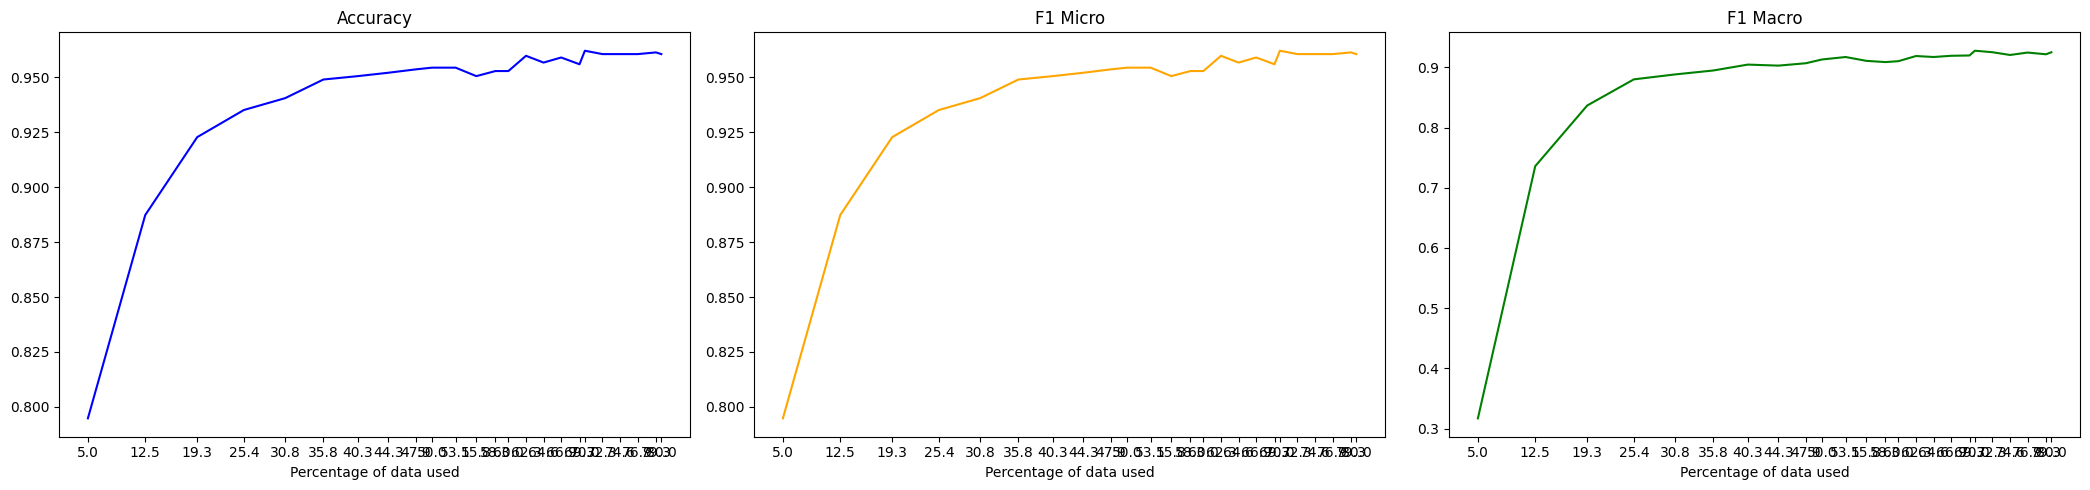

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.606, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4981, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4951, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4838, Accuracy: 0.8013, F1 Micro: 0.8876, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.8058, F1 Micro: 0.8887, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3973, Accuracy: 0.8118, F1 Micro: 0.8907, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3715, Accuracy: 0.8229, F1 Micro: 0.896, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3104, Accuracy: 0.8363, F1 Micro: 0.9029, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6264, Accuracy: 0.7834, F1 Micro: 0.7834, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5982, Accuracy: 0.7834, F1 Micro: 0.7834, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5174, Accuracy: 0.7834, F1 Micro: 0.7834, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4139, Accuracy: 0.7898, F1 Micro: 0.7898, F1 Macro: 0.4694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.364, Accuracy: 0.8217, F1 Micro: 0.8217, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2634, Accuracy: 0.8599, F1 Micro: 0.8599, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1531, Accuracy: 0.8917, F1 Micro: 0.8917, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.843
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.8917, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5901, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5166, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5017, Accuracy: 0.7969, F1 Micro: 0.8845, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4806, Accuracy: 0.8058, F1 Micro: 0.8898, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.409, Accuracy: 0.8304, F1 Micro: 0.9018, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3689, Accuracy: 0.8452, F1 Micro: 0.9091, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3114, Accuracy: 0.8609, F1 Micro: 0.9169, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2559, Accuracy: 0.9122, F1 Micro: 0.9462, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6039, Accuracy: 0.6906, F1 Micro: 0.6906, F1 Macro: 0.4085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5636, Accuracy: 0.6906, F1 Micro: 0.6906, F1 Macro: 0.4085
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4752, Accuracy: 0.8296, F1 Micro: 0.8296, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3005, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.9055
Epoch 5/10, Train Loss: 0.1841, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.888
Epoch 7/10, Train Loss: 0.1363, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8695
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8927
Epoch 9/10, Train Loss: 0.1039, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8916
Epoch 10/10, Train Loss: 0.069, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8695

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5824, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4957, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4708, Accuracy: 0.8028, F1 Micro: 0.8888, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4268, Accuracy: 0.8237, F1 Micro: 0.8984, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3749, Accuracy: 0.8661, F1 Micro: 0.9211, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3043, Accuracy: 0.9249, F1 Micro: 0.9541, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2427, Accuracy: 0.9293, F1 Micro: 0.956, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1966, Accuracy: 0.9323, F1 Micro: 0.9576, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5771, Accuracy: 0.7036, F1 Micro: 0.7036, F1 Macro: 0.413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.486, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.5377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3157, Accuracy: 0.8775, F1 Micro: 0.8775, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2466, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9086
Epoch 5/10, Train Loss: 0.1806, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.87
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8937
Epoch 7/10, Train Loss: 0.148, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9014
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.8541
Epoch 9/10, Train Loss: 0.1352, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0952, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4883, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4524, Accuracy: 0.8199, F1 Micro: 0.8972, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3931, Accuracy: 0.8668, F1 Micro: 0.9209, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3105, Accuracy: 0.9353, F1 Micro: 0.9604, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2398, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1908, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1411, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.1177, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5688, Accuracy: 0.6763, F1 Micro: 0.6763, F1 Macro: 0.4035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3749, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2471, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9341
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9081
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9253, F1 Micro: 0.9253, F1 Macro: 0.9158
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9253, F1 Micro: 0.9253, F1 Macro: 0.9186
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9301
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0838, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5375, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.48, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4466, Accuracy: 0.8251, F1 Micro: 0.9002, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3647, Accuracy: 0.8958, F1 Micro: 0.9375, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2761, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2062, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9686
Epoch 7/10, Train Loss: 0.1493, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0998, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6015, Accuracy: 0.6973, F1 Micro: 0.6973, F1 Macro: 0.4108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4487, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2644, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9011
Epoch 4/10, Train Loss: 0.2181, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2202, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9279
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9237
Epoch 7/10, Train Loss: 0.134, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1495, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.947
Epoch 10/10, Train Loss: 0.0819, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5473, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4809, Accuracy: 0.8036, F1 Micro: 0.8893, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4232, Accuracy: 0.8497, F1 Micro: 0.9123, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3304, Accuracy: 0.9256, F1 Micro: 0.9545, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2486, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.172, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9688
Epoch 7/10, Train Loss: 0.1393, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0889, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6144, Accuracy: 0.6981, F1 Micro: 0.6981, F1 Macro: 0.4111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4172, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8985
Epoch 3/10, Train Loss: 0.2833, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9348
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9298
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.923
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9311
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9185
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9394

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.55, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4751, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.404, Accuracy: 0.8832, F1 Micro: 0.9306, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3039, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2171, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5892, Accuracy: 0.7031, F1 Micro: 0.7031, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4036, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.924
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9291
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9341
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9139
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9221
Epoch 10/10, Train Loss: 0.0658, Accuracy: 0.9258, F1 Micro: 0.9258, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5434, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4614, Accuracy: 0.8199, F1 Micro: 0.8972, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3844, Accuracy: 0.9196, F1 Micro: 0.9512, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2828, Accuracy: 0.9427, F1 Micro: 0.9641, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1821, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9705
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9678
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9531, F1 Micro: 0.9703, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5728, Accuracy: 0.8108, F1 Micro: 0.8108, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3217, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2432, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1957, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9433
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9271
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5368, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4853, Accuracy: 0.8162, F1 Micro: 0.8955, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3814, Accuracy: 0.9092, F1 Micro: 0.9454, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2705, Accuracy: 0.9405, F1 Micro: 0.9626, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1951, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9722
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9546, F1 Micro: 0.9711, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.7004, F1 Micro: 0.7004, F1 Macro: 0.4768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9354
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9479
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4575, Accuracy: 0.8162, F1 Micro: 0.8944, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.372, Accuracy: 0.9263, F1 Micro: 0.9548, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2491, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5664, Accuracy: 0.8549, F1 Micro: 0.8549, F1 Macro: 0.826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9234
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9238
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9467
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9425
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9219

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5372, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4624, Accuracy: 0.8281, F1 Micro: 0.9017, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3712, Accuracy: 0.936, F1 Micro: 0.9609, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2451, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.967
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9761
Epoch 10/10, Train Loss: 0.0578, Accuracy: 0.9628, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.556, Accuracy: 0.686, F1 Micro: 0.686, F1 Macro: 0.4069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3124, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9252
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9201
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9147
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.906
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9106
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.921
Epoch 10/10, Train Loss: 0.0572, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9169

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4611, Accuracy: 0.8445, F1 Micro: 0.9098, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3524, Accuracy: 0.9375, F1 Micro: 0.9613, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2283, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.167, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5344, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9178
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9281
Epoch 8/10, Train Loss: 0.1245, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Epoch 10/10, Train Loss: 0.0769, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5255, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4444, Accuracy: 0.8519, F1 Micro: 0.9136, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3278, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2122, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.977
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.8594, F1 Micro: 0.8594, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9329
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9465
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9426
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9472
Epoch 10/10, Train Loss: 0.0514, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9295

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4476, Accuracy: 0.8743, F1 Micro: 0.9255, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3037, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5085, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9297
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9353
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.956
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.9518
Epoch 10/10, Train Loss: 0.0621, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5307, Accuracy: 0.8006, F1 Micro: 0.8875, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4536, Accuracy: 0.8557, F1 Micro: 0.9155, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3197, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9756
Epoch 6/10, Train Loss: 0.1132, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5361, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9269
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.9513
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9393
Epoch 10/10, Train Loss: 0.0694, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4375, Accuracy: 0.8743, F1 Micro: 0.9255, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2931, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1876, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5182, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9185
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9371
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9347
Epoch 10/10, Train Loss: 0.0506, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4281, Accuracy: 0.8891, F1 Micro: 0.9338, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2822, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.13, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9435
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9428
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9352
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0539, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.7984, F1 Micro: 0.8867, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4333, Accuracy: 0.881, F1 Micro: 0.929, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9793
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4815, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9582, F1 Micro: 0.9582, F1 Macro: 0.9526
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9342
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.935
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9259
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9388
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9177

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5292, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4183, Accuracy: 0.8884, F1 Micro: 0.9333, F1 Macro: 0.9326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2673, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9283
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9356
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5164, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4111, Accuracy: 0.904, F1 Micro: 0.9421, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9613, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5585, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9172
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9293
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9186
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268

Sentiment analysis accuracy: 0.9377, F1 Micro: 0.9377, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4031, Accuracy: 0.8929, F1 Micro: 0.9357, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.258, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0554, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4373, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.94
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9329
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9406
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.905
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9362
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9172
Epoch 10/10, Train Loss: 0.0724, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5172, Accuracy: 0.8065, F1 Micro: 0.8906, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3889, Accuracy: 0.939, F1 Micro: 0.9625, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4642, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Epoch 3/10, Train Loss: 0.1364, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9354
Epoch 4/10, Train Loss: 0.1054, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9064
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9126
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9145
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9009

Sentiment analysis accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5197, Accuracy: 0.8065, F1 Micro: 0.8907, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.409, Accuracy: 0.9003, F1 Micro: 0.9394, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2459, Accuracy: 0.9338, F1 Micro: 0.958, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5546, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9131
Epoch 3/10, Train Loss: 0.1539, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9085
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9321
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9249
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236

Sentiment analysis accuracy: 0.943, F1 Micro: 0.943, F1 M

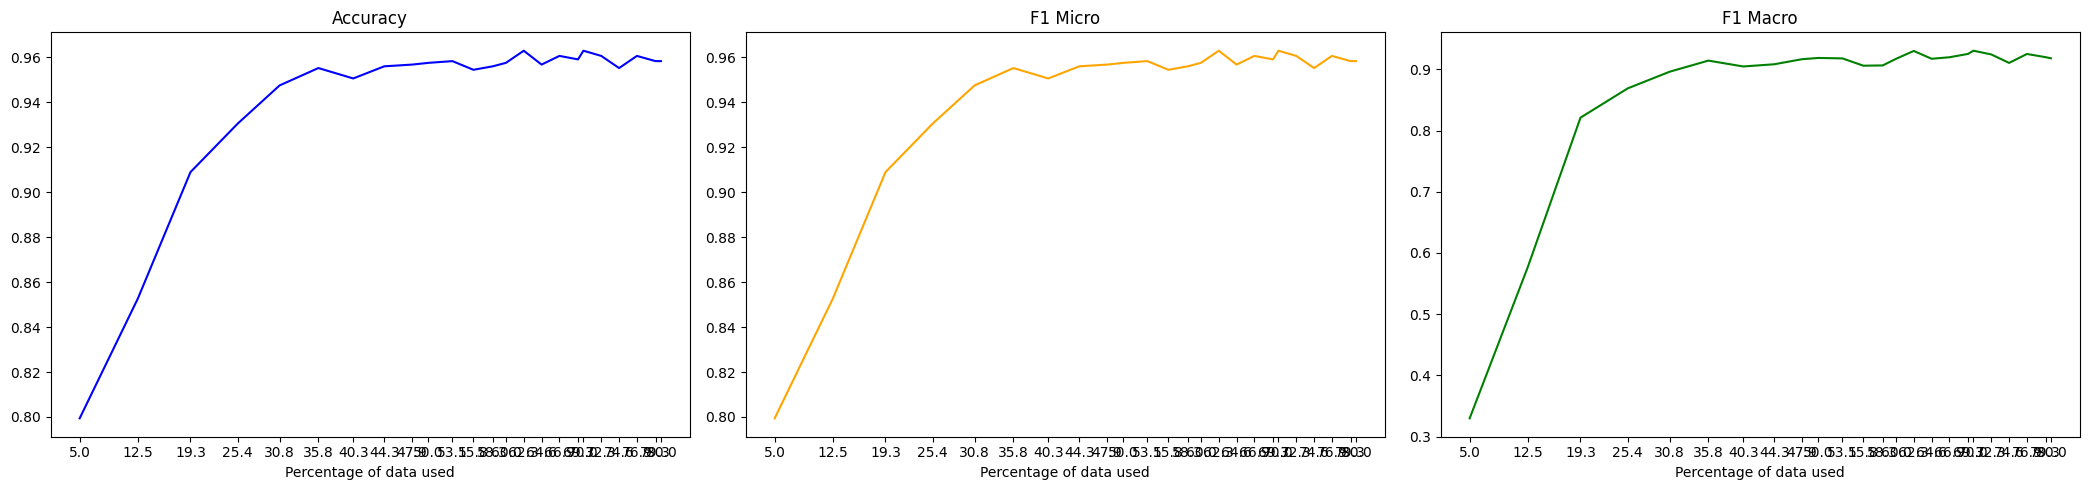

In [ ]:
active_learning(seeds[4], 4)